# Capítulo Empírico: SELIC x Ibovespa

Este notebook organiza todas as etapas necessárias para relacionar a taxa SELIC com o comportamento do Ibovespa. O roteiro segue a sequência:

1. Configurar o ambiente e carregar as bibliotecas utilizadas ao longo da análise.
2. Baixar automaticamente, via MarketDataExporter, as séries do Ibovespa, SELIC efetiva e SELIC meta.
3. Carregar os arquivos JSON persistidos e padronizar colunas e tipos de data.
4. Realizar o merge das séries por data, calcular o retorno do Ibov e criar as defasagens relevantes da SELIC.
5. Explorar os dados com estatísticas descritivas e visualizações.
6. Estimar modelos lineares que quantificam o efeito da SELIC (no tempo presente e defasada) sobre o índice.

Cada seção possui um breve contexto para facilitar a leitura sequencial.

## Configuração das bibliotecas

Importamos as dependências de manipulação (pandas, pathlib), visualização (matplotlib, seaborn), modelagem (statsmodels) e o utilitário MarketDataExporter que encapsula as chamadas à API.

In [2]:
import sys
from pathlib import Path

import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import statsmodels.api as sm

from ibovselic import MarketDataExporter


## Download das séries via API

Define diretórios de saída, janela de datas e utiliza o MarketDataExporter para persistir os arquivos JSON da SELIC (meta e efetiva) e do histórico do Ibovespa em data/raw.

In [3]:

PROJECT_ROOT = Path.cwd().resolve()
SRC_DIR = PROJECT_ROOT / "src"

if SRC_DIR.exists() and str(SRC_DIR) not in sys.path:
    sys.path.insert(0, str(SRC_DIR))


output_dir = PROJECT_ROOT / "data" / "raw"
output_dir.mkdir(parents=True, exist_ok=True)

inicio_analise = 2009
fim_analise = 2024

exporter = MarketDataExporter(data_dir=output_dir)

exporter.export_selic_meta(inicio_analise, fim_analise)
exporter.export_selic(inicio_analise, fim_analise)
exporter.export_ibov(inicio_analise, fim_analise)


[2025-11-02 10:33:06,825] [INFO] Starting export for SELIC serie 4392 (2009-2024)
[2025-11-02 10:33:06,826] [INFO] Requesting block 2009-2018
[2025-11-02 10:33:07,649] [INFO] Requesting block 2019-2024
[2025-11-02 10:33:08,325] [INFO] Done. Saved 192 entries to C:\Users\crist\Documents\projetos\selic-ibovespa-analysis\notebooks\data\raw\history_selic_meta.json
[2025-11-02 10:33:08,326] [INFO] Starting export for SELIC serie 4390 (2009-2024)
[2025-11-02 10:33:08,327] [INFO] Requesting block 2009-2018
[2025-11-02 10:33:08,899] [INFO] Requesting block 2019-2024
[2025-11-02 10:33:09,523] [INFO] Done. Saved 192 entries to C:\Users\crist\Documents\projetos\selic-ibovespa-analysis\notebooks\data\raw\history_selic.json
[2025-11-02 10:33:09,524] [INFO] Starting export for IBOVESPA (2009-2024)
[2025-11-02 10:33:09,525] [INFO] Requesting block 2009-2018
[2025-11-02 10:33:10,048] [INFO] Requesting block 2019-2024
[2025-11-02 10:33:10,588] [INFO] Done. Saved 192 entries to C:\Users\crist\Documents\

WindowsPath('C:/Users/crist/Documents/projetos/selic-ibovespa-analysis/notebooks/data/raw/history_ibov.json')

## Carregar e padronizar os arquivos JSON

Transforma cada arquivo em DataFrame, converte date_reference para datetime e renomeia as colunas numéricas para manter uma nomenclatura consistente (ibov, selic_mensal, selic_meta).

In [4]:
pasta_arquivos= Path("data/raw")
ibov = pd.read_json(pasta_arquivos / "history_ibov.json")               # Ibov Acumulado
selic = pd.read_json(pasta_arquivos / "history_selic.json")             # acumulada % a.m.
selic_meta = pd.read_json(pasta_arquivos / "history_selic_meta.json")   # meta % a.a.

# Converter datas
for df in [ibov, selic, selic_meta]:
    df["date_reference"] = pd.to_datetime(df["date_reference"])

# Renomear colunas de valor
ibov = ibov.rename(columns={"value": "ibov"})
selic = selic.rename(columns={"value": "selic_mensal"})
selic_meta = selic_meta.rename(columns={"value": "selic_meta"})


## Consolidar séries e derivar métricas

Realiza o merge das bases pelo campo date_reference, calcula o retorno percentual mensal do Ibovespa (ibov_return) e remove linhas iniciais com nulos decorrentes do cálculo do retorno.

In [5]:
df = (
    ibov[["date_reference","ibov"]]
    .merge(selic[["date_reference","selic_mensal"]], on="date_reference")
    .merge(selic_meta[["date_reference","selic_meta"]], on="date_reference")
)

#ibov return
df["ibov_return"] = df["ibov"].pct_change() * 100
df = df.dropna().reset_index(drop=True)

df.head(10)


,date_reference,ibov,selic_mensal,selic_meta,ibov_return
0,2009-02-01,38183.31,0.86,12.62,-2.843403
1,2009-03-01,40925.87,0.97,11.65,7.182615
2,2009-04-01,47289.53,0.84,11.05,15.549236
3,2009-05-01,53197.73,0.77,10.10,12.493675
4,2009-06-01,51465.46,0.76,9.40,-3.256286
5,2009-07-01,54765.72,0.79,8.93,6.412573
6,2009-08-01,56488.98,0.69,8.62,3.146603
7,2009-09-01,61517.89,0.69,8.62,8.902462
8,2009-10-01,61545.50,0.69,8.62,0.044881
9,2009-11-01,67044.44,0.66,8.63,8.934756


## Construir defasagens da SELIC (Distributed Lag)

Gera as colunas selic_meta_m0 a selic_meta_m12, representando a taxa meta atual e suas defasagens mensais, que servirão como regressores no modelo de defasagens distribuídas.

In [15]:
periodo_defasagem = 12 # número de meses
for k in range(0, periodo_defasagem+1):
    df[f"selic_meta_m{k}"] = df["selic_meta"].shift(k)

lags_meta = [f"selic_meta_m{k}" for k in range(0,periodo_defasagem+1)]


## Estatísticas descritivas

Apresenta as métricas básicas para IBOV, retornos e taxas SELIC, além da matriz de correlação para investigar associações preliminares entre as variáveis.

In [47]:
# Estatistica descritiva
print("Tabela 1: Estatísticas Descritivas das Variáveis de 2010 a 2025\n")
print(df[["ibov","selic_meta_m0", "selic_meta_m3", "selic_meta_m6", "selic_meta_m12"]].describe())

# Correlação
print("\nTabela 2: Matriz de correlação entre a Ibovespa e Selic no mês com defasagens de 12 meses\n")
print(df[["ibov","selic_meta_m0", "selic_meta_m3", "selic_meta_m6", "selic_meta_m12"]].corr())


Tabela 1: Estatísticas Descritivas das Variáveis de 2010 a 2025

                ibov  selic_meta_m0  selic_meta_m3  selic_meta_m6  \
count     191.000000     191.000000     188.000000     185.000000   
mean    79440.877874       9.493037       9.466543       9.450865   
std     27308.688385       3.381905       3.401821       3.427177   
min     38183.310000       1.900000       1.900000       1.900000   
25%     56290.735000       6.950000       6.937500       6.930000   
50%     67705.400000      10.320000      10.300000      10.140000   
75%    104783.880000      12.070000      12.100000      12.130000   
max    136004.010000      14.140000      14.140000      14.140000   

       selic_meta_m12  
count      179.000000  
mean         9.402793  
std          3.473241  
min          1.900000  
25%          6.800000  
50%         10.000000  
75%         12.205000  
max         14.140000  

Tabela 2: Matriz de correlação entre a Ibovespa e Selic no mês com defasagens de 12 meses

     

## Gráficos comparativos

Visualiza a evolução histórica do Ibovespa, da SELIC meta atual e das versões defasadas (6 e 12 meses) para identificar tendências e deslocamentos temporais entre as séries.

Gráfico 1:  Evolução do IBOVESPA e Meta Selic com Defasagens m3, m6 e m12, no periodo de 2010 a 2024


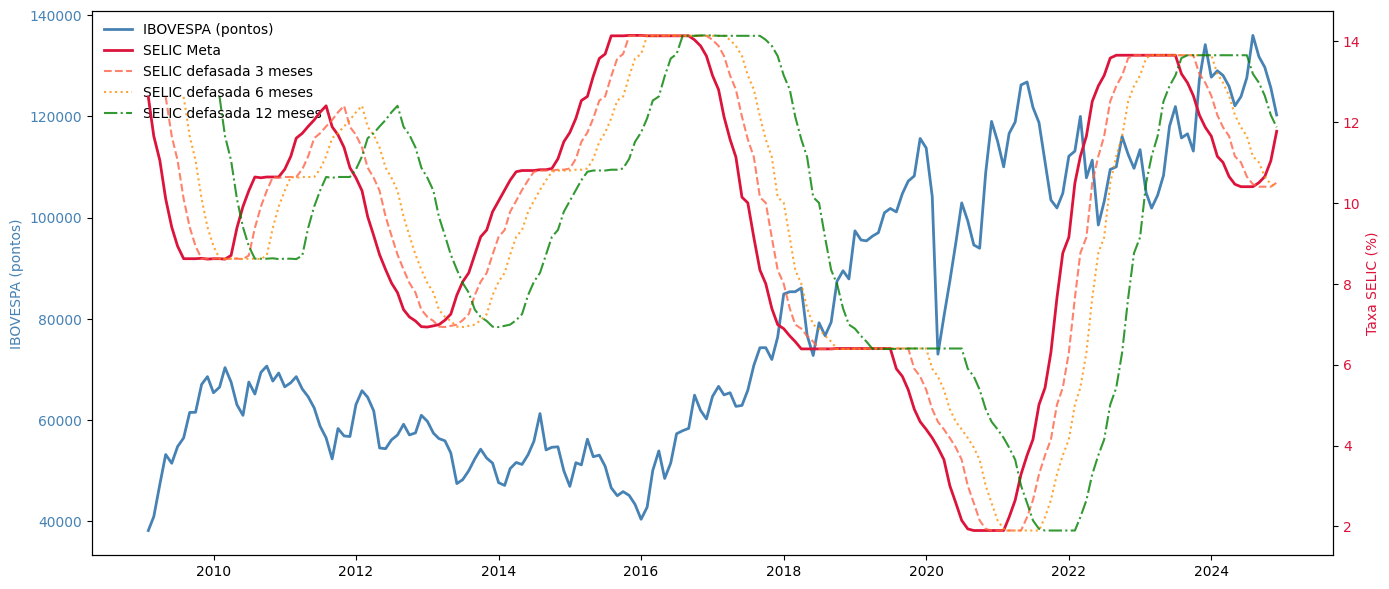

In [48]:
fig, ax1 = plt.subplots(figsize=(14, 6))

# Eixo principal → IBOVESPA
ax1.plot(
    df["date_reference"],
    df["ibov"],
    label="IBOVESPA (pontos)",
    color="steelblue",
    linewidth=2,
)
ax1.set_ylabel("IBOVESPA (pontos)", color="steelblue")
ax1.tick_params(axis="y", labelcolor="steelblue")
# ax1.set_title("Evolução do IBOVESPA e Meta Selic com Defasagens m3, m6 e m12, no periodo de 2010 a 2024", fontsize=13)

# Segundo eixo → SELIC e defasagens
ax2 = ax1.twinx()
ax2.plot(
    df["date_reference"],
    df["selic_meta"],
    label="SELIC Meta",
    color="crimson",
    linewidth=2,
)
ax2.plot(
    df["date_reference"],
    df["selic_meta_m3"],
    label="SELIC defasada 3 meses",
    color="tomato",
    linestyle="--",
    alpha=0.8,
)
ax2.plot(
    df["date_reference"],
    df["selic_meta_m6"],
    label="SELIC defasada 6 meses",
    color="darkorange",
    linestyle=":",
    alpha=0.8,
)
ax2.plot(
    df["date_reference"],
    df["selic_meta_m12"],
    label="SELIC defasada 12 meses",
    color="green",
    linestyle="-.",
    alpha=0.8,
)
ax2.set_ylabel("Taxa SELIC (%)", color="crimson")
ax2.tick_params(axis="y", labelcolor="crimson")

# Legenda combinada (IBOV + SELICs)
lines_1, labels_1 = ax1.get_legend_handles_labels()
lines_2, labels_2 = ax2.get_legend_handles_labels()
ax1.legend(lines_1 + lines_2, labels_1 + labels_2, loc="upper left", frameon=False)

print("Gráfico 1:  Evolução do IBOVESPA e Meta Selic com Defasagens m3, m6 e m12, no periodo de 2010 a 2024")
plt.tight_layout()
plt.show()


## Estimar regressão linear Simples

Ajusta um modelo OLS com intercepto usando as defasagens da SELIC meta (selic_meta_m0 a selic_meta_m12).

In [37]:
X = sm.add_constant(df["selic_meta"])  # regressora
y = df["ibov"]                    # dependente

ols_model = sm.OLS(y, X).fit()

print("Figura 1:  Resultados do Modelo MQO para o IBOVESPA\n")
print(ols_model.summary())

Figura 1:  Resultados do Modelo MQO para o IBOVESPA

                            OLS Regression Results                            
Dep. Variable:                   ibov   R-squared:                       0.078
Model:                            OLS   Adj. R-squared:                  0.073
Method:                 Least Squares   F-statistic:                     15.96
Date:                Sun, 02 Nov 2025   Prob (F-statistic):           9.26e-05
Time:                        11:52:10   Log-Likelihood:                -2213.8
No. Observations:                 191   AIC:                             4432.
Df Residuals:                     189   BIC:                             4438.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------

## Estimar regressão linear com defasagens

Ajusta um modelo OLS com intercepto usando as defasagens da SELIC meta (selic_meta_m0 a selic_meta_m12) como regressores para quantificar o efeito temporal sobre o Ibovespa.

In [53]:
# Seleciona as variáveis m0 até m12
lags_m = [f"selic_meta_m{k}" for k in range(0, periodo_defasagem + 1)]

# Monta X e Y, garantindo alinhamento temporal
X = sm.add_constant(df[lags_m].dropna())
y = df["ibov"].iloc[len(df) - len(X):]

# Estima o modelo DLM
print("Figura 2:  Resultados do Modelo MQO com Defasagens Distribuídas (DLM) para o IBOVESPA\n")
model = sm.OLS(y, X).fit()
print(model.summary())


Figura 2:  Resultados do Modelo MQO com Defasagens Distribuídas (DLM) para o IBOVESPA

                            OLS Regression Results                            
Dep. Variable:                   ibov   R-squared:                       0.133
Model:                            OLS   Adj. R-squared:                  0.065
Method:                 Least Squares   F-statistic:                     1.953
Date:                Sun, 02 Nov 2025   Prob (F-statistic):             0.0277
Time:                        13:06:58   Log-Likelihood:                -2069.5
No. Observations:                 179   AIC:                             4167.
Df Residuals:                     165   BIC:                             4212.
Df Model:                          13                                         
Covariance Type:            nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------

## Relação SELIC x Ibov atual

Gera um gráfico regplot do Seaborn para comparar a SELIC mensal e o nível do Ibovespa, adicionando a linha de tendência estimada para apoiar uma avaliação visual da relação contemporânea entre as séries.

Gráfico 2: Relação entre SELIC mensal (% a.m.) e Retorno IBOV (% ao mês)



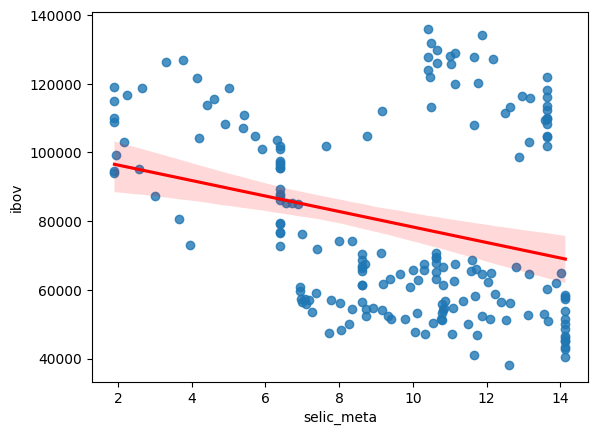

In [49]:
sns.regplot(x="selic_meta", y="ibov", data=df, ci=95, line_kws={"color":"red"})
print("Gráfico 2: Relação entre SELIC mensal (% a.m.) e Retorno IBOV (% ao mês)\n")
# plt.title("Relação entre SELIC mensal (% a.m.) e Retorno IBOV (% ao mês)")
plt.show()

## Efeitos defasados da Selic sobre o Ibov

Grafico 3: Efeitos Defasados da SELIC sobre o IBOV (Modelo DLM)


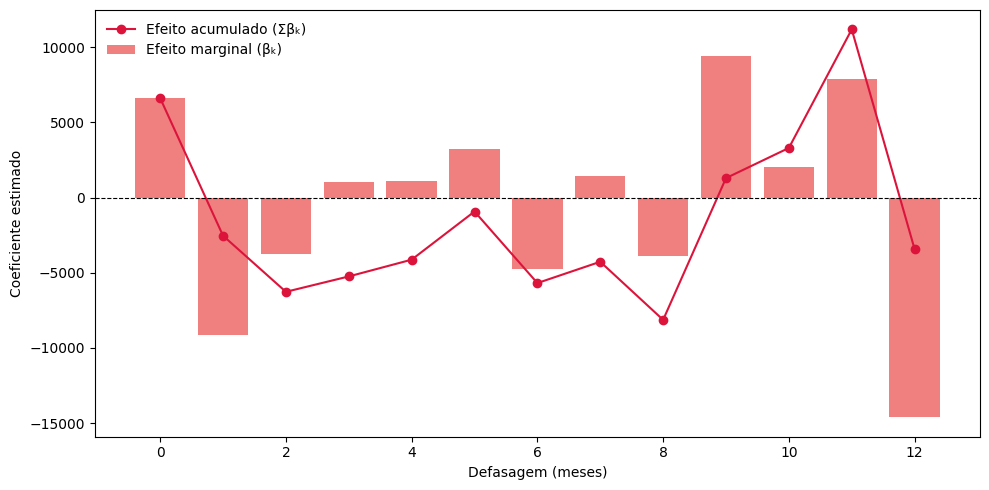

In [55]:


# Extrai coeficientes das defasagens (do modelo DLM já ajustado)
coef_lags = model.params.filter(like="selic_meta")

# Cria DataFrame com efeito acumulado
df_effect = (
    pd.DataFrame({
        "defasagem": range(len(coef_lags)),
        "coeficiente": coef_lags.values
    })
    .assign(efeito_acumulado=lambda d: d["coeficiente"].cumsum())
)

# Plot: efeito individual + acumulado
fig, ax = plt.subplots(figsize=(10, 5))

ax.bar(df_effect["defasagem"], df_effect["coeficiente"], label="Efeito marginal (βₖ)", color="lightcoral")
ax.plot(df_effect["defasagem"], df_effect["efeito_acumulado"], label="Efeito acumulado (Σβₖ)", color="crimson", marker="o")

ax.axhline(0, color="black", linewidth=0.8, linestyle="--")
# ax.set_title("Efeitos Defasados da SELIC sobre o IBOV (Modelo DLM)", fontsize=13)
ax.set_xlabel("Defasagem (meses)")
ax.set_ylabel("Coeficiente estimado")
ax.legend(frameon=False)
plt.tight_layout()
print("Grafico 3: Efeitos Defasados da SELIC sobre o IBOV (Modelo DLM)")
plt.show()

